<a href="https://colab.research.google.com/github/dibahk/Applied-Statistics/blob/main/01_Autoregressive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt

# Autoregressive linear model

* In this lab session, you will implement an *autoregressive* linear model that can be used to predict a time series.

* Autoregressive models are extremely important in machine learning.

* All large language models are autoregressive models.


# Dataset generation

* In this time series prediction task, the dataset will be composed of a sequence of points $x_1, x_2, \ldots, x_{n}$, where each point is a real number and $n = 1000$.

* In contrast to the previous tasks (regression and classification), there is no pre-defined target associated to each point.

* Instead, the goal is to predict the next point in the sequence, which presumes the existence of a *pattern*.

* We will generate a dataset by adding noise to a known function. For every $t \in \{1, \ldots, n\}$, we will let $x_t = f(t) + \epsilon_t$, where $\epsilon_t$ is sampled from a normal distribution.

* The following code generates and plots the dataset.

In [ ]:
def f(t, noise_std):
    return torch.sin(0.1 * t) * torch.exp(-0.001 * t) + torch.normal(0, noise_std, t.shape)

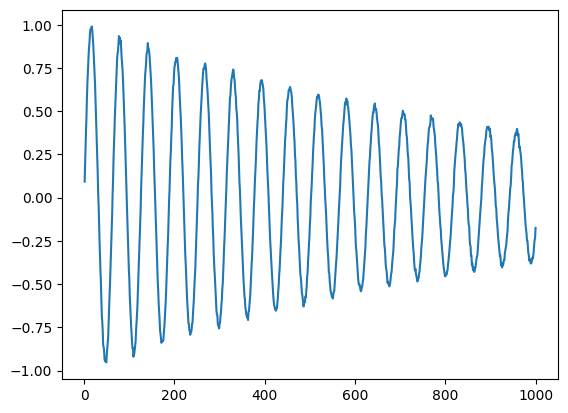

In [ ]:
T = 1000  # Generates a total of 1000 points
noise_std = 0.01 # Standard deviation of the noise added to each point. The noise is sampled from a normal distribution.
time = torch.arange(1, T + 1, dtype=torch.float32)

x = f(time, noise_std) # Applies `f` elementwise to the vector `time` and adds noise to each element.

plt.plot(time, x);

* Can you guess how a linear model can be used to predict the last $400$ points given the first $600$ points?

# Task 1

* Your first task is to transform the original sequence $x_1, x_2, \ldots, x_{n}$ into a regression dataset in order to enable linear regression.

* For a given hyperparameter $\tau$ called window size, you will allow the regression model to use the last $\tau$ points to predict the next point.

* The regression dataset should be given by $(\mathbf{x}^{(\tau + 1)}, y^{(\tau + 1)}), (\mathbf{x}^{(\tau + 2)}, y^{(\tau + 2)}), \ldots, (\mathbf{x}^{(n)}, y^{(n)})$. Note that the first prediction will require observing the first $\tau$ points, so the regression dataset has $\tau$ fewer elements than the original dataset.

* For every $t \in \{\tau + 1, \ldots, n \}$, let $\mathbf{x}^{(t)} = [x_{t - \tau}, x_{t - \tau + 1},  \ldots, x_{t - 1}]^T$ be the observation (input) and $y^{(t)} = x_{t}$ be the target (output).

* You should initially let $\tau = 4$, so that the regression dataset is given by

$$([x_1, x_2, x_3, x_4]^T, x_5), ([x_2, x_3, x_4, x_5]^T, x_6), \ldots, ([x_{996}, x_{997}, x_{998}, x_{999}]^T, x_{1000}). $$

* After you have created this regression dataset, store the observations in a design matrix called `features`, where each (transposed) observation corresponds to a row. Furthermore, store the targets in a target vector called `labels`. You should use a PyTorch `tensor` to store each of these tensors.

* **Hint**: Each column of the design matrix `features` follows a simple pattern.


In [ ]:
# TODO: Write your code to generate the design matrix `features` and the target vector `labels`.
tau = 10 # Your code should work for any window size defined here.
features = torch.zeros(T-tau, tau)
for i in range(tau):
  features[:, i] = x[i:T-tau+i]
labels = x[tau:].reshape(-1, 1)

In [ ]:
# TODO: Print the first seven elements of the vector `x` and the first three rows of the design matrix `features` and the target vector `labels`. Make sure that the data is organized correctly.
print(x[:7])
print(features[:3])
print(labels[:3])

tensor([0.0926, 0.1971, 0.2925, 0.3869, 0.4611, 0.5731, 0.6547])
tensor([[0.0926, 0.1971, 0.2925, 0.3869, 0.4611, 0.5731, 0.6547, 0.7125, 0.7703,
         0.8379],
        [0.1971, 0.2925, 0.3869, 0.4611, 0.5731, 0.6547, 0.7125, 0.7703, 0.8379,
         0.8704],
        [0.2925, 0.3869, 0.4611, 0.5731, 0.6547, 0.7125, 0.7703, 0.8379, 0.8704,
         0.9094]])
tensor([[0.8704],
        [0.9094],
        [0.9593]])


# Task 2

* You will now select a part of your regression dataset to create a training dataset. You will also create an object that allows generating batches of examples from this training dataset.

* Select the first $600$ examples from `features` and `labels` and create a `torch.utils.data.TensorDataset` object called `dataset`.

* After you have a `torch.utils.data.TensorDataset` object, you should create a `torch.utils.data.DataLoader` object called `data_iter`. The batch size should be $16$.

* We have already used these classes in a previous notebook. You can find their documentation and source code [here](https://pytorch.org/docs/stable/data.html).

* **From now on, you will often be required to search the official documentation (or other sources) to learn how to use PyTorch functionalities. This will prepare you to solve problems beyond this module.**

In [ ]:
# TODO: Write your code to create the `torch.utils.data.TensorDataset` and the `torch.utils.data.DataLoader` objects described above
n_train = 600 # Number of examples in the training dataset
batch_size = 16
dataset = torch.utils.data.TensorDataset(features[:n_train], labels[:n_train])
data_iter = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=True)


# Task 3

* Create a `torch.nn.Linear` object callled `net` to represent your linear model.
* Initialize the parameters of this linear model:
    * The weights should be sampled from a normal distribution with standard deviation $0.01$.
    * The bias should be zero.
* Create a `torch.nn.MSELoss` object called `loss` to represent your loss function.
* Create a `torch.optim.SGD` object called `optimizer` to implement minibatch stochastic gradient descent. Set the learning rate to $0.01$

* Write a function called `evaluate` that receives the parameters `net`, `data_iter`, and `loss`. This function should accumulate the `loss` of the `net` across batches generated by `data_iter` and return the mean loss. Note that the gradients of the losses computed by this function are not required.

* Write a function called `train` that receives the parameters `net`, `data_iter`, `loss`, `optimizer`, and `epochs`. This function should train the  `net` for the specified number of `epochs`. Every $50$ epochs, the function `train` should call and print the return of the function `evaluate`.

* Finally, `train` your `net` for $400$ `epochs`.

In [ ]:
# TODO: Write your code for Task #3 here.
num_inputs = tau
num_outputs = 1
net = torch.nn.Linear(num_inputs, num_outputs)
net.weight.data.normal_(0,0.01)
net.bias.data.fill_(0)

loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

def evaluate(net, data_iter, loss):
  l = torch.tensor(0.0)
  n = torch.tensor(0.0)
  with torch.no_grad():
    for X, y in data_iter:
      l += loss(net(X), y)
      n += len(y)
  return l/n

def train(net, data_iter, loss, optimizer, epochs):
    for epoch in range(epochs):
      for X, y in data_iter:
        y_ = net(X)
        l = loss(y_, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
      if epoch % 50 == 0:
          print(f'Epoch: {epoch}. Loss: {evaluate(net, data_iter, loss):f}')


train(net, data_iter, loss, optimizer, 400)

Epoch: 0. Loss: 0.003856
Epoch: 50. Loss: 0.000046
Epoch: 100. Loss: 0.000045
Epoch: 150. Loss: 0.000044
Epoch: 200. Loss: 0.000048
Epoch: 250. Loss: 0.000043
Epoch: 300. Loss: 0.000042
Epoch: 350. Loss: 0.000042


# Task 4

* You will now check the predictions that your linear model makes in the training dataset.

* Because `net` is a `torch.nn.Module`, it implements a `__call__` method that should be used to make predictions. The method `__call__` allows a Python object to be called as if it were a Python function.

* You should call `net(features)` to obtain a prediction vector (containing the prediction for each row in `features`).

* Because each observation is used to make a prediction one step ahead, we are making so-called one-step predictions.

* The code below is able to plot the original dataset and the one step predictions.

* The code below also prints the weights and the bias vector. Write down the equation that computes the prediction $\hat{x}_{t+1}$ given $[x_{t - \tau + 1}, x_{t - \tau + 2}, \ldots, x_{t}]^T$. Can you interpret this prediction?


In [ ]:
# TODO: Write your code to obtain the predictions for the `features` by calling `net`
onestep_preds = net(features)

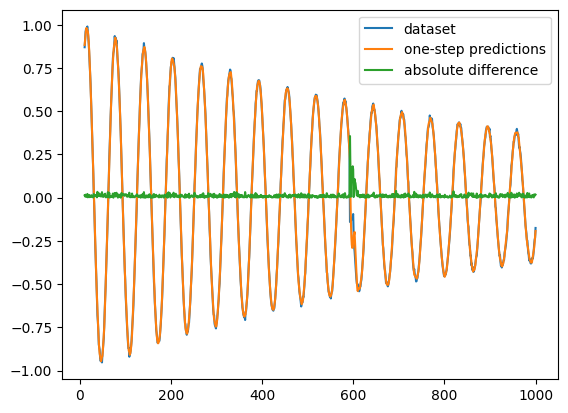

Parameter containing:
tensor([[-0.1993, -0.1020, -0.0426, -0.0141,  0.0412,  0.0827,  0.1385,  0.2176,
          0.3207,  0.4548]], requires_grad=True)
Parameter containing:
tensor([-0.0002], requires_grad=True)


In [ ]:
# Plots the original dataset, the one step predictions, and their absolute difference.
onestep_preds = onestep_preds.detach().numpy()

plt.plot(time[tau:], labels, label='dataset')
plt.plot(time[tau:], onestep_preds, label='one-step predictions')
plt.plot(time[tau:], torch.abs(labels - onestep_preds), label='absolute difference')
plt.legend(loc='best')
plt.show()

# Prints the parameters of the linear model
print(net.weight)
print(net.bias)

# Task 5

* The quality of the one-step predictions is highly misleading about the capabilities of this linear model.

* This is because predicting a single time step into the future is not very useful. In order to predict farther into the future, this model would have to rely on its own predictions of intermediary points.

* For example, if the last $400$ points of the original dataset were not available, the predictions $\hat{x}_{601}, \hat{x}_{602}, \ldots, \hat{x}_{1000}$ could be obtained by
$$
\hat{x}_{601} = [x_{587}, x_{598}, x_{599}, x_{600}] \cdot \mathbf{w} + b, \\
\hat{x}_{602} = [x_{598}, x_{599}, x_{600}, \hat{x}_{601}] \cdot \mathbf{w} + b, \\
\hat{x}_{603} = [x_{599}, x_{600}, \hat{x}_{601}, \hat{x}_{602}] \cdot \mathbf{w} + b, \\
\hat{x}_{604} = [x_{600}, \hat{x}_{601}, \hat{x}_{602}, \hat{x}_{603}] \cdot \mathbf{w} + b, \\
\hat{x}_{605} = [\hat{x}_{601}, \hat{x}_{602}, \hat{x}_{603}, \hat{x}_{604}] \cdot \mathbf{w} + b, \\
\vdots \\
\hat{x}_{1000} = [\hat{x}_{996}, \hat{x}_{997}, \hat{x}_{998}, \hat{x}_{999}] \cdot \mathbf{w} + b,
$$
where $\mathbf{w}$ are the weights and $b$ is the bias of the linear model.

* In the previous example, because the initial observation $[x_{587}, x_{598}, x_{599}, x_{600}]^T$ is used to predict multiple steps ahead, we are making so-called multi-step predictions.

* A model that receives its own predictions in order to make additional predictions is considered autoregressive.

* Your next task is to use the last observation  $[x_{587}, x_{598}, x_{599}, x_{600}]^T$ of your training dataset to compute the multi-step predictions $\hat{x}_{601}, \hat{x}_{602}, \ldots, \hat{x}_{1000}$. You should store the multi-step predictions in a $400 \times 1 $ `tensor` called `multistep_preds`.

* You will have to compute one prediction at a time, since each prediction depends on the previous predictions.


In [ ]:
# TODO: Write your code to compute the multi-step prediction tensor `multistep_preds`
x_last = x[n_train - tau :n_train].reshape(1, tau) # The last observation in the training set.
multistep_preds = torch.zeros(400, 1)
with torch.no_grad():
  for i in range(400):
    multistep_preds[i] = net(x_last)
    x_last[0,0:-1] = x_last[0, 1:].clone()
    x_last[0, -1] = multistep_preds[i]

# Task 6

* The following code plots the original dataset together with the multi-step predictions.

* How does the result relate with your interpretation of this linear model?

* Rerun this notebook (Runtime > Restart session and run all) for different window sizes $\tau$. What do you observe?

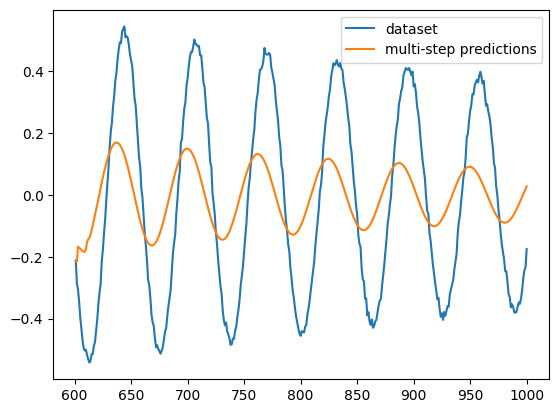

In [ ]:
plt.plot(time[n_train:], labels[n_train - T:], label='dataset')
plt.plot(time[n_train:], multistep_preds, label='multi-step predictions')
plt.legend(loc='best')
plt.show()

* You will learn to implement much more powerful autoregressive models in this module.